# How to Use this notebook

**For a test run**: 
- In "Kernel" select "Restart and Clear Output"
- then use Shift + Enter to run the individual cells after setting them up

**if all cells are correctly set up**: just press "Run"

This notebook can only be used after running **"Process_Tracks"** notebook.
It will aggregate the data that has been aligned to a reference time and generate different figures.
Various filtering steps and quality control steps can be performed



In [27]:
%matplotlib notebook

In [28]:
import os
import glob
import re
import numpy as np
import pandas as pd
import seaborn as sns

import networkx as nx

import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
from mpl_toolkits import mplot3d

In [29]:
plt.rcParams.update({'figure.max_open_warning': 0})

# Aggregate data

## define folder containing processed data

In [30]:
# Define folder containing the processed data
base_input_path = r"E:\_OUTPUT\_RUNS\RUN_Endo\Analysis_Output\Movies"
input_files = glob.glob(os.path.join(base_input_path,"**/*.csv"),recursive=True)
print("nb. of files:",len(input_files))

nb. of files: 14


## TO BE DONE define siRNA conditions included REUSE FURTHER DOWN

In [31]:
# Define conditions (in ALL CAPS)
conditions = ["UNTREATED"]
# conditions = ["SICTRL","SITNKS","SINUMA","SITNKS-SINUMA"]

In [32]:
# Aggregating...

# Create "Aggregation" subfolder
base_input_spath = os.path.join(base_input_path,"Aggregation")
if not os.path.exists(base_input_spath):
    os.makedirs(base_input_spath)
    
# Create "Tables" subfolder
base_input_spath_table = os.path.join(base_input_path,"Aggregation","Tables")
if not os.path.exists(base_input_spath_table):
    os.makedirs(base_input_spath_table)
    
# Create "Figures" subfolder
base_input_spath_fig = os.path.join(base_input_path,"Aggregation","Figures")
if not os.path.exists(base_input_spath_fig):
    os.makedirs(base_input_spath_fig)

    # Create "box" subfolder
base_input_spath_box = os.path.join(base_input_path,"Aggregation","Figures", "box")
if not os.path.exists(base_input_spath_box):
    os.makedirs(base_input_spath_box)
    
   # Create "box" subfolder
base_input_spath_swarm = os.path.join(base_input_path,"Aggregation","Figures", "swarm")
if not os.path.exists(base_input_spath_swarm):
    os.makedirs(base_input_spath_swarm)

# Limit directories to be checked
sub_path = "ANALYSED_CSV"
sub_path2 = "PROCESSED_CSV"

trackinfo = []
movie_col, cond_col, date_col, clone_col = [], [], [], []
df = pd.DataFrame() # empty df

for f in input_files:
    sf = f.split(base_input_path)[1].upper() # exclude base path and make all to upper case
    if sub_path2 in sf: # if the file is in processed_csv dir
        dftmp = pd.read_csv(f)
        if len(dftmp)>0:
            
            info = np.load(os.path.join(f.split("Processed_CSV")[0],"trackinfo.npy"),allow_pickle=True).item()

            # tracks excluded by border violation
            trackinfo += [(info["Movie"],item,"border_violated") for item in np.setdiff1d(info["total_tracks"],info["tracks_border_filtered"])]
            
            # tracks excluded by border transistion violation
            trackinfo += [(info["Movie"],item,"transistion_violated") for item in np.setdiff1d(info["tracks_border_filtered"],info["tracks_transistion_filtered"])]

            # tracks excluded by time alignment convention
            trackinfo += [(info["Movie"],item,"alignment_violated") for item in np.setdiff1d(info["tracks_transistion_filtered"],info["tracks_time_aligned"])]
            
            # tracks remain
            trackinfo += [(info["Movie"],item,"passed") for item in info["tracks_time_aligned"]]
    
    elif sub_path in sf: # if the file is in analysed_csv dir
        condlst = []
        for c in conditions: # check conditions
            if c in sf:
                condlst.append(c)
        if len(condlst)>0: # if the file is in a condition
            # assign best fit condition
            imax = np.argmax([len(c) for c in condlst])
            condlbl = condlst[imax]
        
            match_day = re.search(r'\d{8}', sf) # searching date pattern
            match_clone = re.search(r"_CL(.+)_",os.path.basename(sf)) # searching clone pattern
            if (match_clone is None): # if failed, try another template for clone pattern
                match_clone = re.search(r"_CL(.+)\.",os.path.basename(sf))
            if (match_day is not None) & (match_clone is not None): # find it!
                datelbl = "d"+match_day.group()
                clonelbl = "cl"+match_clone.group(1)
                moviename = os.path.basename(sf).split(".CSV")[0]
                dftmp = pd.read_csv(f)
                if len(dftmp)>0:
                    movie_col += [moviename for _ in range(len(dftmp))]
                    cond_col += [condlbl for _ in range(len(dftmp))]
                    date_col += [datelbl for _ in range(len(dftmp))]
                    clone_col += [clonelbl for _ in range(len(dftmp))]
                    df = df.append(dftmp) 
                    
dftrackinfo = pd.DataFrame(trackinfo,columns=["Movie","TrackObjects_Label","Status"])
                    
df["Movie"] = movie_col
df["Condition"] = cond_col
df["Date"] = date_col
df["Clone"] = clone_col
df["Index"] = range(len(df))
df.set_index("Index",inplace=True)

## Tracks info table

This table indicate status of track: **passed** or **excluded** (violation of border, transistion rule or alignment rule)

In [33]:
dftrackinfo

,Movie,TrackObjects_Label,Status
0,Untreated_20180427_Pos01_cl16,10.0,border_violated
1,Untreated_20180427_Pos01_cl16,12.0,border_violated
2,Untreated_20180427_Pos01_cl16,15.0,border_violated
3,Untreated_20180427_Pos01_cl16,19.0,border_violated
4,Untreated_20180427_Pos01_cl16,21.0,border_violated
...,...,...,...
110,Untreated_20180427_Pos07_cl16,15.0,alignment_violated
111,Untreated_20180427_Pos07_cl16,16.0,alignment_violated
112,Untreated_20180427_Pos07_cl16,19.0,alignment_violated
113,Untreated_20180427_Pos07_cl16,20.0,passed


In [34]:
print("total tracks:",len(dftrackinfo))
print("tracks excluded by border:",len(dftrackinfo[dftrackinfo["Status"]=="border_violated"]))
print("tracks excluded by transistion:",len(dftrackinfo[dftrackinfo["Status"]=="transistion_violated"]))
print("tracks excluded by time alignment:",len(dftrackinfo[dftrackinfo["Status"]=="alignment_violated"]))
print("tracks remain:",len(dftrackinfo[dftrackinfo["Status"]=="passed"]))

total tracks: 115
tracks excluded by border: 48
tracks excluded by transistion: 0
tracks excluded by time alignment: 49
tracks remain: 18


In [35]:
# Save to file
filename = os.path.join(base_input_spath_table,"tracks_info.csv")
dftrackinfo.to_csv(filename,index=False)

## Aligned tracks table

This table show tracks after time points alignment (only for **passed** tracks).

In [36]:
df.head(10) # display top 10 rows

,Nucleus_State_Number,Reference_Time,ImageNumber,ObjectNumber,TrackObjects_Label,AreaShape_Area,AreaShape_Perimeter,AreaShape_FormFactor,Intensity_IntegratedIntensity_H2B_Smooth,Intensity_IntegratedIntensity_TRF1_Smooth,...,Mean_Telomere_AreaShape_Perimeter,Mean_Telomere_Distance_Minimum_Nuclei,Mean_Telomere_Distance_Centroid_Nuclei,Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth,Children_Telomere_Count,Nucleus_State_Name,Movie,Condition,Date,Clone
Index,,,,,,,,,,,,,,,,,,,,,
0,1.0,-0.5,1.0,3.0,3.0,12842.0,443.546248,0.820285,253.602258,90.844181,...,16.368198,22.602343,38.334289,0.386293,107.0,interphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
1,3.0,-0.4,2.0,3.0,3.0,12500.0,453.445743,0.763958,302.707569,78.743981,...,14.148932,20.220292,41.103920,0.274684,99.0,prometaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
2,3.0,-0.3,3.0,3.0,3.0,6030.0,386.090404,0.508334,158.797156,33.781060,...,11.332500,12.780186,26.406370,0.183542,43.0,prometaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
3,3.0,-0.2,4.0,2.0,3.0,7509.0,481.203102,0.407507,184.343942,38.004314,...,8.614721,14.494553,32.647097,0.111571,26.0,prometaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
4,4.0,-0.1,5.0,2.0,3.0,6427.0,369.362482,0.591988,172.371500,34.046691,...,7.635127,15.629081,25.697516,0.102704,15.0,metaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
5,4.0,0.0,6.0,2.0,3.0,6674.0,364.469083,0.631357,182.881819,32.248588,...,7.383452,14.457420,28.272760,0.088245,10.0,metaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
6,5.0,0.3,9.0,3.0,3.0,6605.0,343.563492,0.703183,191.143841,32.623001,...,17.071068,26.819430,16.111255,0.408716,1.0,anaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
7,5.0,0.4,10.0,4.0,3.0,3735.0,259.237590,0.698400,107.508798,18.293892,...,7.799832,15.942923,14.949144,0.120057,6.0,anaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16
8,5.0,0.5,11.0,4.0,3.0,3979.0,270.107648,0.685346,106.941134,17.901706,...,9.232488,17.272165,12.614974,0.126051,7.0,anaphase,UNTREATED_20180427_POS01_CL16,UNTREATED,d20180427,cl16


## Features Available

In [37]:
print("List of features can be used in plots:")
[print(col) for col in df.columns];

List of features can be used in plots:
Nucleus_State_Number
Reference_Time
ImageNumber
ObjectNumber
TrackObjects_Label
AreaShape_Area
AreaShape_Perimeter
AreaShape_FormFactor
Intensity_IntegratedIntensity_H2B_Smooth
Intensity_IntegratedIntensity_TRF1_Smooth
Intensity_MeanIntensity_H2B_Smooth
Intensity_MeanIntensity_TRF1_Smooth
Mean_Telomere_AreaShape_Area
Mean_Telomere_AreaShape_Perimeter
Mean_Telomere_Distance_Minimum_Nuclei
Mean_Telomere_Distance_Centroid_Nuclei
Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth
Children_Telomere_Count
Nucleus_State_Name
Movie
Condition
Date
Clone


**optional: add column based on calculation from existing colums**

In [38]:
 df["AreaShape_Circularity"] = df["AreaShape_Perimeter"] / (2* np.sqrt(np.pi*df["AreaShape_Area"]))

## Save Aligned Tracks and Features as CSV

In [39]:
# save to file
filename = os.path.join(base_input_spath_table,"aligned_tracks.csv")
df.to_csv(filename,index=False)

## States table

This table specifies state name and its ID.

In [40]:
state_df = df[["Nucleus_State_Number","Nucleus_State_Name"]].drop_duplicates().set_index("Nucleus_State_Number")["Nucleus_State_Name"]
state_df.sort_index(inplace=True)
print(state_df)

Nucleus_State_Number
1.0      interphase
2.0        prophase
3.0    prometaphase
4.0       metaphase
5.0        anaphase
Name: Nucleus_State_Name, dtype: object


In [41]:
# save to file
filename = os.path.join(base_input_spath_table,"states.csv")
state_df.reset_index().to_csv(filename,index=False)

## Transistion probability table

This table provides probability for each transistion.

In [42]:
# build pb graph
G=nx.DiGraph()
G.add_nodes_from(state_df.values);
for name in state_df.values:
    G.add_edge(name,name,label=[])
for i in range(len(state_df)-1):
    for j in range(1,len(state_df)):
        G.add_edge(state_df.iloc[i],state_df.iloc[j],label=[])
        G.add_edge(state_df.iloc[j],state_df.iloc[i],label=[])

# retrieve npy files storing state transistion matrices
npy_files = glob.glob(os.path.join(base_input_path,"**/*.npy"),recursive=True)
print("nb. of files:",len(npy_files))

# count transistion cases
valid_files = []
for f in npy_files:
    matching = re.search(r"1border",os.path.basename(f)) 
    if matching is not None:
        valid_files.append(f)
        M = np.load(f)
        for ir in range(M.shape[0]):
            r = M[ir]
            
            total_cases = len(r[r!=0])
            if total_cases > 0:
                G2=nx.DiGraph()
                G2.add_nodes_from(state_df.values);
                for name in state_df.values:
                    G2.add_edge(name,name,label=0.)
                for i in range(len(state_df)-1):
                    for j in range(1,len(state_df)):
                        G2.add_edge(state_df.iloc[i],state_df.iloc[j],label=0.)
                        G2.add_edge(state_df.iloc[j],state_df.iloc[i],label=0.)

                for i in range(len(r)-1):
                    if((r[i]!=0) & (r[i+1]!=0)):
                        G2.edges[state_df[r[i]],state_df[r[i+1]]]["label"] += 1.

                for key, val in G2.edges.items():
                    G.edges[key[0],key[1]]["label"].append(G2.edges[key[0],key[1]]["label"]/total_cases)
                    
# build pb dataframe
edge_dic = nx.get_edge_attributes(G,"label")
pbdf = pd.Series(index=list(edge_dic.keys()), data=[np.mean(val) for val in edge_dic.values()], name='Probability')
pbdf = np.round(pbdf*100,2)  
pbdf.index.name = "Group"
print("transistion probability (%)")
print(pbdf)

nb. of files: 20
transistion probability (%)
Group
(interphase, interphase)        74.79
(interphase, prophase)           0.27
(interphase, prometaphase)       1.41
(interphase, metaphase)          0.03
(interphase, anaphase)           0.10
(prophase, prophase)             0.05
(prophase, interphase)           0.27
(prophase, prometaphase)         0.00
(prophase, metaphase)            0.00
(prophase, anaphase)             0.00
(prometaphase, prometaphase)     0.94
(prometaphase, interphase)       0.61
(prometaphase, prophase)         0.00
(prometaphase, metaphase)        0.40
(prometaphase, anaphase)         0.14
(metaphase, metaphase)           0.07
(metaphase, interphase)          0.02
(metaphase, prophase)            0.00
(metaphase, prometaphase)        0.00
(metaphase, anaphase)            0.28
(anaphase, anaphase)             1.92
(anaphase, interphase)           0.20
(anaphase, prophase)             0.00
(anaphase, prometaphase)         0.26
(anaphase, metaphase)            0.00

In [43]:
# save to file
filename = os.path.join(base_input_spath_table,"transistion_probability.csv")
pbdf.reset_index().to_csv(filename,index=False)

# Number of tracked objects by Reference time

Check how many objects were tracked upto a given ref time.

<IPython.core.display.Javascript object>


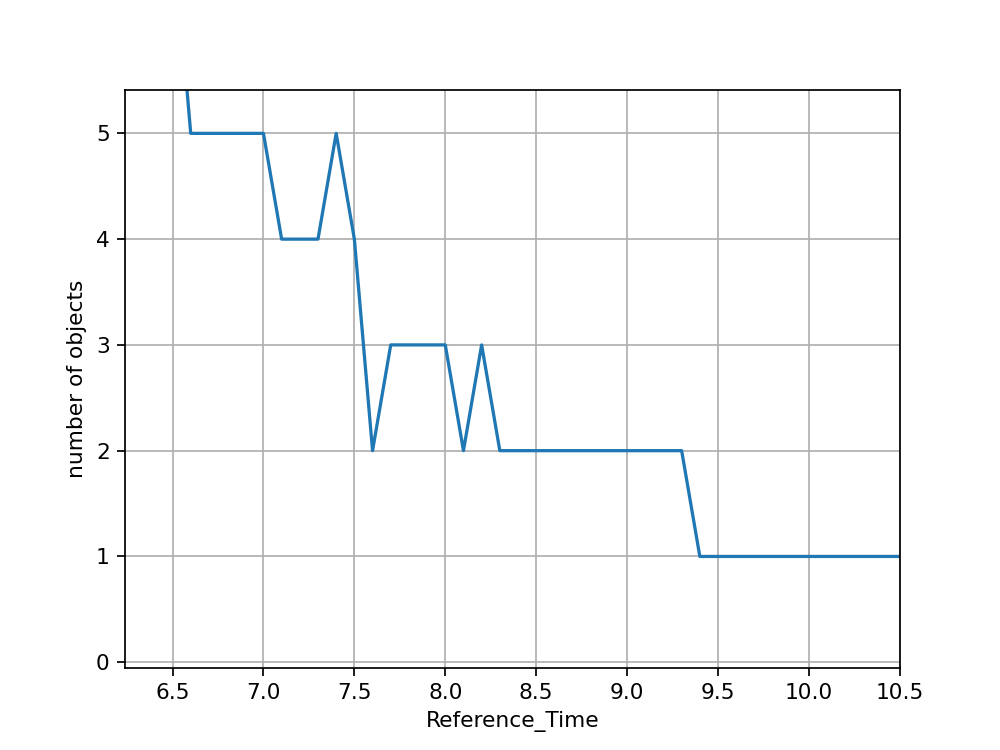

In [44]:
# group by reference times and count number of cases
gr = df.groupby("Reference_Time").count()["Nucleus_State_Number"]
fig = plt.figure()
ax = fig.add_subplot(111)
gr.plot(ax=ax)
ax.set_ylabel("number of objects");
ax.grid();

**Comments**: there're not many objects can be tracked beyond +-15 hours.

In [45]:
# save fig
filename = os.path.join(base_input_spath_fig,"1_Number_Tracked_Objects_by_RefTime.png")
fig.savefig(filename,dpi=300)

## Clip dataframe within ref time interval

Observing the above plot, we can limit the data into a ref time interval. Here I chose [-10,10] since the number of tracked objects > 15 which might be good for stats ?

In [47]:
sdf = df.copy()

# Define reference time interval thr1 > thr2 eg thr1, thr2 = 6,-1
thr1, thr2 = 8,-2
sdf = sdf[(sdf["Reference_Time"]<=thr1)&(sdf["Reference_Time"]>=thr2)]

print("nb. of tracks after clip:",np.sum([len(item) for item in sdf.groupby(["Movie"])["TrackObjects_Label"].unique().values]))

nb. of tracks after clip: 18


# Filter tracks

We may want to filter tracks based on some criteria.

## OPTIONAL Max telomere count in interphase

This filtering step is to remove low TRF1-GFP expressors or cells that have silenced the expression of the transgene.
it is optional

# Tracks summary

Show some summaries per track e.g. track duration, mitotic duration, etc.

In [50]:
print("nb. of tracks after filtering:",np.sum([len(item) for item in sdf.groupby(["Movie"])["TrackObjects_Label"].unique().values]))

nb. of tracks after filtering: 14


## Mitotic duration

In [51]:
# Define mitotic states
mitotic = ["prophase","prometaphase","metaphase","anaphase"]

super_data = []
for ix, gr in sdf.groupby(["Movie","TrackObjects_Label"]):
    track_duration = (len(gr)-1)*0.1
    mitotic_duration = (len(gr[gr["Nucleus_State_Name"].isin(mitotic)])-1)*0.1
    if mitotic_duration < 0:
        mitotic_duration = 0
    super_data.append((ix[0],ix[1],
                       track_duration,mitotic_duration,
                       gr["Condition"].values[0],gr["Date"].values[0],gr["Clone"].values[0]))
    
superdf = pd.DataFrame(super_data,columns=["Movie","TrackObjects_Label",
                                           "Track_Duration","Mitotic_Duration",
                                           "Condition","Date","Clone"])
superdf.set_index(["Movie","TrackObjects_Label"],inplace=True)

In [52]:
superdf

Track_Duration  \
Movie                         TrackObjects_Label                   
UNTREATED_20180427_POS01_CL16 3.0                            7.1   
                              7.0                            4.7   
                              9.0                            7.5   
                              14.0                           7.9   
UNTREATED_20180427_POS04_CL16 7.0                            1.5   
                              13.0                           4.3   
                              16.0                           6.9   
                              17.0                           6.4   
                              18.0                           6.3   
UNTREATED_20180427_POS05_CL16 4.0                            7.6   
                              25.0                           7.4   
                              27.0                           5.6   
UNTREATED_20180427_POS07_CL16 20.0                           1.0   
                              25.0                           0.0   

                                                  Mitotic_Duration  Condition  \
Movie                         TrackObjects_Label                                
UNTREATED_20180427_POS01_CL16 3.0                              1.4  UNTREATED   
                              7.0                              0.3  UNTREATED   
                              9.0                              0.2  UNTREATED   
                              14.0                             0.2  UNTREATED   
UNTREATED_20180427_POS04_CL16 7.0                              1.5  UNTREATED   
                              13.0                             0.0  UNTREATED   
                              16.0                             0.0  UNTREATED   
                              17.0                             0.1  UNTREATED   
                              18.0                             0.5  UNTREATED   
UNTREATED_20180427_POS05_CL16 4.0                              0.5  UNTREATED   
                              25.0                             0.1  UNTREATED   
                              27.0                             0.0  UNTREATED   
UNTREATED_20180427_POS07_CL16 20.0                             0.3  UNTREATED   
                              25.0                             0.0  UNTREATED   

                                                       Date Clone  
Movie                         TrackObjects_Label                   
UNTREATED_20180427_POS01_CL16 3.0                 d20180427  cl16  
                              7.0                 d20180427  cl16  
                              9.0                 d20180427  cl16  
                              14.0                d20180427  cl16  
UNTREATED_20180427_POS04_CL16 7.0                 d20180427  cl16  
                              13.0                d20180427  cl16  
                              16.0                d20180427  cl16  
                              17.0                d20180427  cl16  
                              18.0                d20180427  cl16  
UNTREATED_20180427_POS05_CL16 4.0                 d20180427  cl16  
                              25.0                d20180427  cl16  
                              27.0                d20180427  cl16  
UNTREATED_20180427_POS07_CL16 20.0                d20180427  cl16  
                              25.0                d20180427  cl16

In [53]:
# save to file
filename = os.path.join(base_input_spath_table,"Mitosis_Length.csv")
superdf.reset_index().to_csv(filename,index=False)

<IPython.core.display.Javascript object>


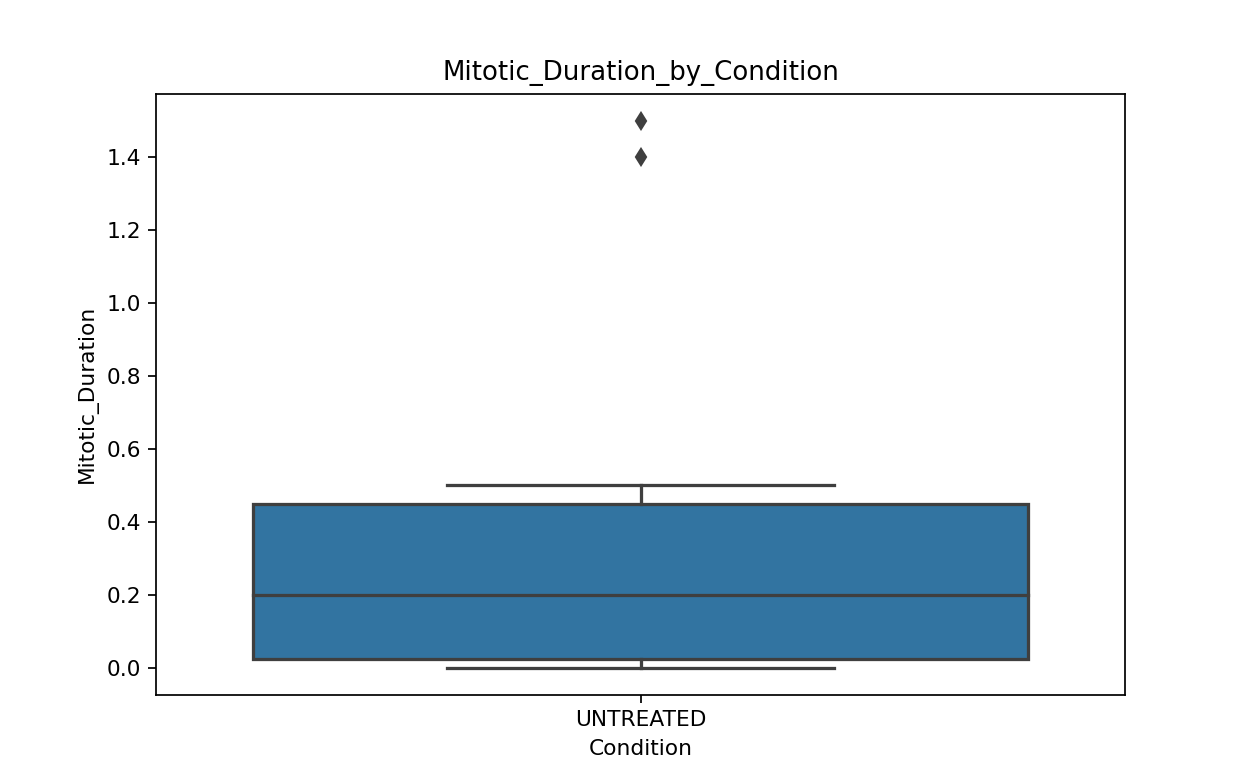

In [54]:
# boxplot
xvar = "Condition"
yvar = "Mitotic_Duration"
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.boxplot(x=xvar, y=yvar, data=superdf);
ax.set_title(yvar+"_by_"+xvar);

In [55]:
# save fig
filename = os.path.join(base_input_spath_box,"Mitotic_Duration_{}.png".format(xvar))
fig.savefig(filename,dpi=300)

## Track duration

<IPython.core.display.Javascript object>


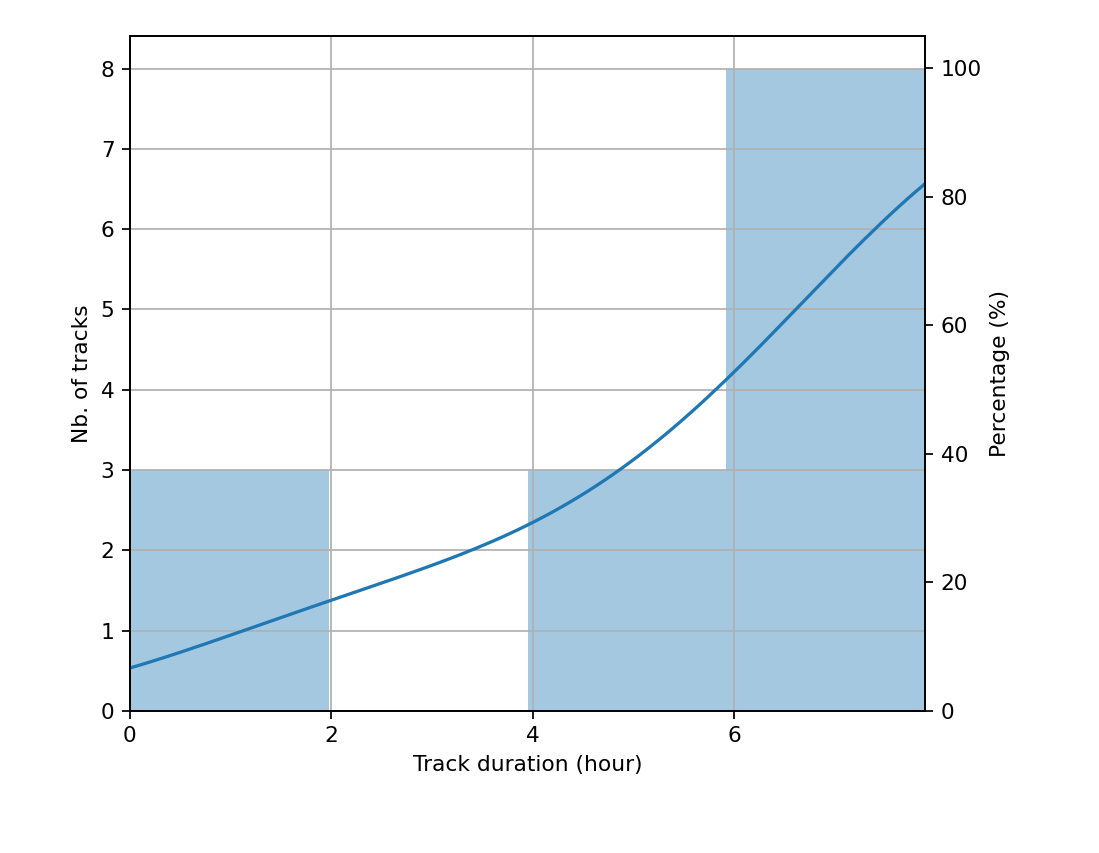

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


In [56]:
fig = plt.figure(figsize=(4.5,3.5))
ax = fig.add_subplot(111)
sns.distplot(superdf["Track_Duration"].values,kde=False,norm_hist=False)
ax.grid();
ax.set_xlabel("Track duration (hour)");
ax.set_ylabel("Nb. of tracks");

ax2=ax.twinx()
kwargs = {'cumulative': True}
sns.kdeplot(superdf["Track_Duration"].values,cumulative=True)
ax2.set_ylabel("Percentage (%)");
ax2.set_yticklabels((ax2.get_yticks()*100.).astype(np.int));
ax2.set_xlim(superdf["Track_Duration"].min(),superdf["Track_Duration"].max());
ax2.set_xticks(np.arange(superdf["Track_Duration"].min(),superdf["Track_Duration"].max()+1,2));
plt.tight_layout();

In [1]:
# save fig
filename = os.path.join(base_input_spath_fig,"Track_Duration.png")
fig.savefig(filename,dpi=300)

NameError: name 'os' is not defined

# TO CHECK Heatmap - MAKE IT FOR ALL CONDITIONS DEFINED in 2.2

## State transisions

In [58]:
feature = "Nucleus_State_Number"
# feature_min, feature_max = sdf[feature].min(), sdf[feature].max()
feature_min, feature_max = int(sdf[feature].min()), int(sdf[feature].max())

<IPython.core.display.Javascript object>


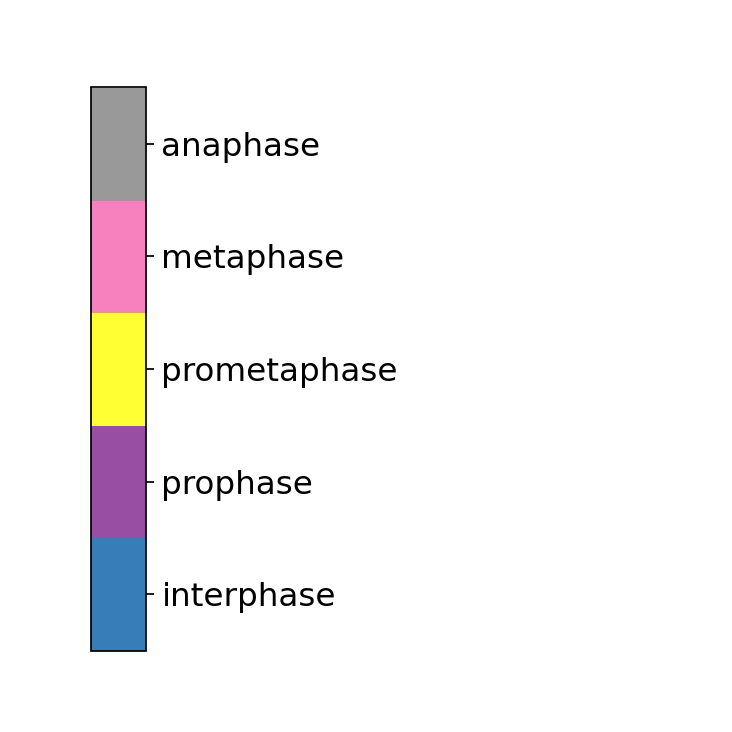

In [59]:
# custom colorbar can be Accent_r, or Set1...
basecmap = cm.get_cmap("Set1",feature_max+1)
mycmap = ListedColormap(basecmap(np.arange(feature_min,feature_max+1)/(feature_max)))


fig, ax = plt.subplots(figsize=(3, 3))
fig.subplots_adjust(right=0.2)

norm = mpl.colors.Normalize(vmin=feature_min-0.5, vmax=feature_max+0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mycmap, 
                                norm=norm, orientation='vertical')

cb1.set_ticks(np.arange(feature_min,feature_max+1))
ax.set_yticklabels([state_df[i] for i in np.arange(feature_min,feature_max+1)],fontsize=15,color="k");
# cb1.set_label("state",fontsize=15,color="k");

<IPython.core.display.Javascript object>


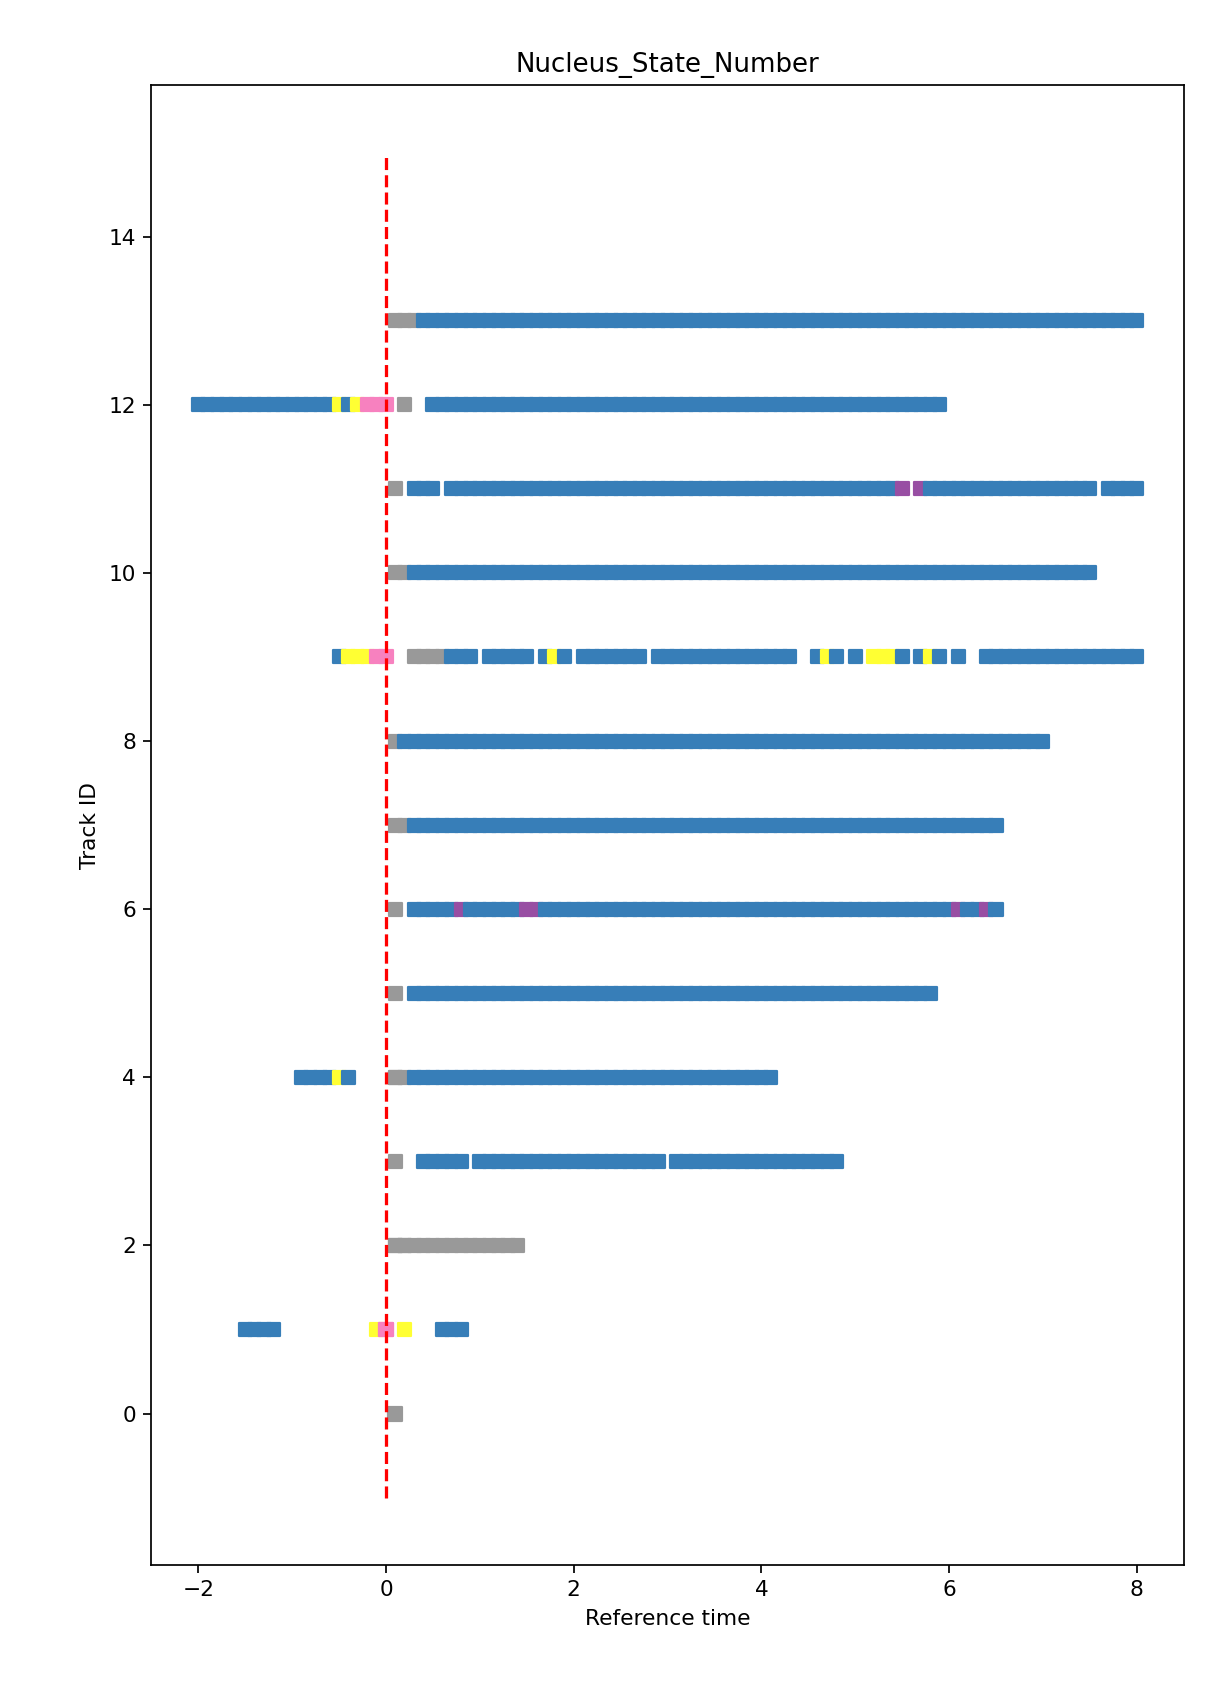

In [60]:
# Define condition
cond = "UNTREATED"
ssdf = sdf[sdf["Condition"]==cond]

ssdflen = ssdf.groupby(["Movie","TrackObjects_Label"])["Reference_Time"].count()*0.1
sort_ix = ssdflen.sort_values(ascending=True).index

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)

item = 0
track_ids = []
for six in sort_ix:
    movie, track = six[0], six[1]
    tmp = ssdf[(ssdf["Movie"]==movie)&(ssdf["TrackObjects_Label"]==track)]
    ax.scatter(tmp["Reference_Time"],[item for _ in range(len(tmp))],
               c=tmp[feature],marker="s",cmap=mycmap,vmin=feature_min,vmax=feature_max)
    item += 1
    track_ids.append((movie,track))
        
ax.vlines(0,-1,item+1,color="r",linestyle="dashed")

ax.set_xlabel("Reference time")
ax.set_ylabel("Track ID");
# ax.invert_yaxis();
ax.set_title(feature);
plt.tight_layout();

In [61]:
# save fig
filename = os.path.join(base_input_spath_fig,"4_Heatmap_States_{}.png".format(cond))
fig.savefig(filename,dpi=300)

### TO BE CHECKED - set up variable for condition in 2.2 and reuse here?

**Is it possible to use the conditions set up in 2.2 as a variable here?** to have it set up at the beginning for the entire notebook and only specify if want to test a single condition...

## Optional check outliers tracks

To activate cell set as "Code"

To deactivate cell set as "Raw NBConvert"

## Other features

In [62]:
# Define feature
feature = "Children_Telomere_Count"
feature_min = sdf[feature].min()
feature_max = np.percentile(sdf[feature],95) # clip the display values <= 95th percentile for clear viz
print(feature_min,feature_max)

1.0 62.25


<IPython.core.display.Javascript object>


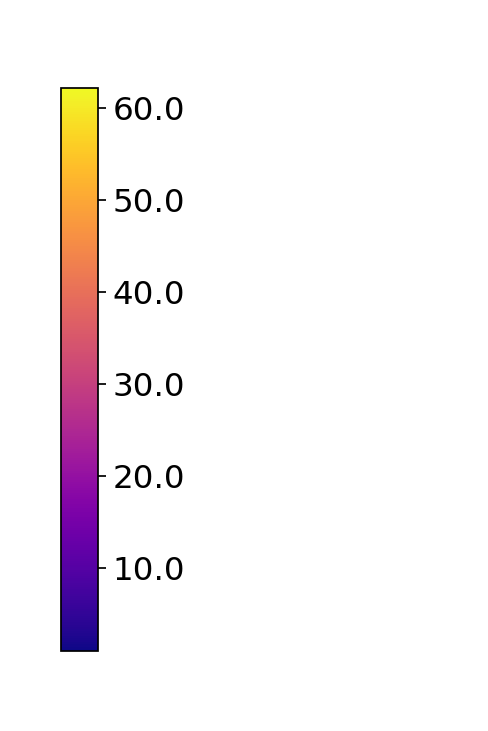

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


In [63]:
# custom colorbar
mycmap = cm.get_cmap("plasma") # choose colormap 

fig, ax = plt.subplots(figsize=(2, 3))
fig.subplots_adjust(right=0.2)

norm = mpl.colors.Normalize(vmin=feature_min, vmax=feature_max)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mycmap, norm=norm, orientation='vertical')

ax.set_yticklabels(np.round(cb1.get_ticks(),2),fontsize=15,color="k");
# cb1.set_label("averaged branchings",fontsize=15,color="k");

<IPython.core.display.Javascript object>


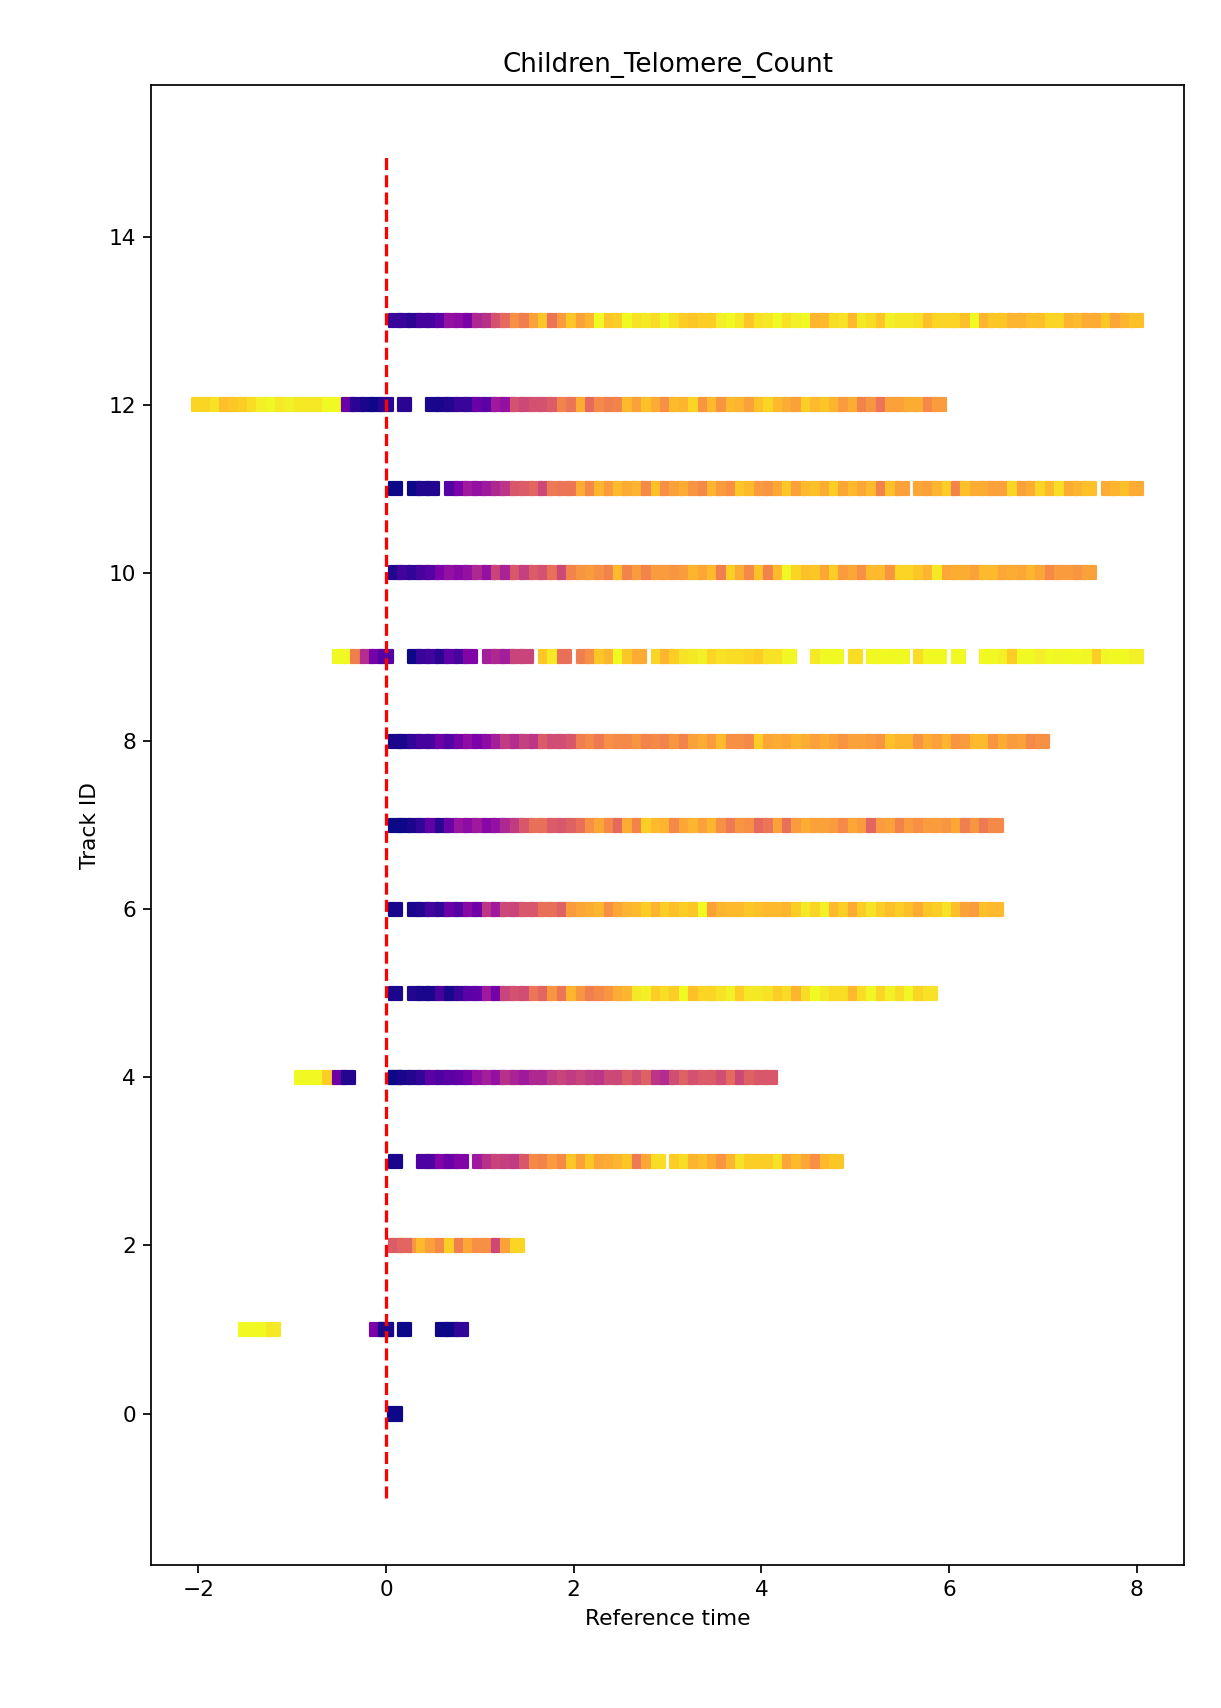

In [64]:
# Define condition
cond = "UNTREATED"
ssdf = sdf[sdf["Condition"]==cond]

ssdflen = ssdf.groupby(["Movie","TrackObjects_Label"])["Reference_Time"].count()*0.1
sort_ix = ssdflen.sort_values(ascending=True).index

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)

item = 0
track_ids = []
for six in sort_ix:
    movie, track = six[0], six[1]
    tmp = ssdf[(ssdf["Movie"]==movie)&(ssdf["TrackObjects_Label"]==track)]
    ax.scatter(tmp["Reference_Time"],[item for _ in range(len(tmp))],
               c=tmp[feature],marker="s",cmap=mycmap,vmin=feature_min,vmax=feature_max)
    item += 1
    track_ids.append((movie,track))
        
ax.vlines(0,-1,item+1,color="r",linestyle="dashed")

# ax.grid("on");
ax.set_xlabel("Reference time")
ax.set_ylabel("Track ID")
ax.set_title(feature);
plt.tight_layout();

In [65]:
# save fig
filename = os.path.join(base_input_spath_fig,"5_Heatmap_{}_{}.png".format(feature,cond))
fig.savefig(filename,dpi=300)

**Optional**: get track information using the track ID (y absciss - can zoom in)

To activate cell set as "Code"

To deactivate cell set as "Raw NBConvert"

### TO BE CHECKED Batch processing (remove cell if not needed) - save in FIGs folder

In [ ]:
# "Children_Telomere_Count","AreaShape_Area","AreaShape_FormFactor","Intensity_IntegratedIntensity_TRF1_Smooth","Intensity_MeanIntensity_H2B_Smooth","Mean_Telomere_Distance_Minimum_Nuclei"

# Plots by reference time

This section studies how feature change w.r.t. reference time.

## Optional: Single feature processing

To activate cell set as "Code"

To deactivate cell set as "Raw NBConvert"


Set "yvar" by a feature we would like to plot. You can set "huevar" by "Condition", "Date", or "Clone".


**Note**: Set "ci=68" equals to "SE" in case of normal distribution assumption (large sample size).

Link: 
- https://academic.csuohio.edu/kneuendorf/c53102/hand12.pdf
- https://github.com/mwaskom/seaborn/issues/1427

## Batch processing

Can set multiple features (make sure they are aligned ie no additional indentation)

Can set the differences by ["Condition","Date", "Clone"]

Set the error bar: ci="sd" for standadrt deviation or ci=95 for 95% confidence interval

In [66]:
xvar = "Reference_Time"

# set your features in yvar
yvars = ["Children_Telomere_Count",
        "Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth",
        "AreaShape_Area",
        "AreaShape_FormFactor",
        "Intensity_IntegratedIntensity_TRF1_Smooth",
        "Intensity_MeanIntensity_H2B_Smooth",
        "Mean_Telomere_Distance_Minimum_Nuclei"]

huevars = ["Condition"] # can be Condition, Date, Clone 

for huevar in huevars:
    for yvar in yvars:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # can set ci=95 for 95% confident interval of mean by bootstraping, but take more time
        sns.lineplot(x=xvar, y=yvar, data=sdf, hue=huevar, ci=95); 
        ax.set_title(yvar + " by " + xvar);
        ax.grid();
        filename = os.path.join(base_input_spath_fig,yvar+"_by_"+xvar+"_"+huevar+".png")
        fig.savefig(filename,dpi=300)
        plt.close(fig) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plots by state transistions

This section studies how feature change among nucleus state transistions.

## Basic (single features)

To run single features only

To activate cell set as "Code"

To deactivate cell set as "Raw NBConvert"

Run the cell below if we want study only a specific group (SICTRL, SINUMA or SITNKS). Otherwise ignore it.

**NOTE**: when we would like to change the filtered conditions (as in the cell above). We should run this section again from the begining to get rid of errors.

Plotting:

Set "yvar" by a feature we would like to plot. You can set "huevar" by "Condition", "Date", or "Clone".

Run the cell below for swarm plot.
**Note**: it takes much longer than boxplot.

## Batch processing

### Boxplot

**NOTE**: you can create a subfolder in "Figures" to save your batch processed plots 

Just specify it in the path for filename below as in this example:

filename = os.path.join(base_input_spath_fig,**"Swarm"**,yvar+"_by_"+xvar+"_"+huevar+"_"+condlbl+"_swarmplot.png")

**YOU NEED TO CREATE THE FOLDER FIRST BEFORE RUNNING**


Specify features and conditions below (indicated by SPECIFY)

In [68]:
ssdf = sdf.copy() # make a copy

# SPECIFY filter by condition
    # set condlbl = None if we don't want to filter, but can  None, "SICTRL", "SINUMA", etc
condlbl = None 
if condlbl is not None:
    c1 = (ssdf["Condition"]==condlbl) 
    ssdf = ssdf[c1]
    
# setting plot variables
xvar = "Nucleus_State_Name"
xorder = ["interphase","prophase","prometaphase","metaphase","anaphase"]
xvar_sup = "Nucleus_State_Number"

# SPECIFY your features to plot
yvars = ["Children_Telomere_Count",
        "Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth",
        "AreaShape_Area",
        "AreaShape_FormFactor",
        "Intensity_IntegratedIntensity_TRF1_Smooth",
        "Intensity_MeanIntensity_H2B_Smooth",
        "Mean_Telomere_Distance_Minimum_Nuclei"]

# SPECIFY group to plot
huevars = ["Condition"] # can be "Condition", "Date", "Clone" or multiple groups ["Clone","Date"]
    
# boxplot
for huevar in huevars:
    for yvar in yvars:
        # computing medians
        grmed = ssdf.groupby([huevar,xvar_sup])[yvar].median()
        huelbl = grmed.index.get_level_values(huevar).unique().values
        
        # plotting
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        sns.boxplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder);
        ax.set_title(yvar+"_by_"+xvar);
        if condlbl is not None:
            filename = os.path.join(base_input_spath_fig,"box",yvar+"_by_"+xvar+"_"+huevar+"_"+condlbl+"_boxplot.png")
        else:
            filename = os.path.join(base_input_spath_fig,"box",yvar+"_by_"+xvar+"_"+huevar+"_boxplot.png")
        fig.savefig(filename,dpi=300)
        plt.close(fig)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TO BE CHECKED Swarmplot --> SPLIT VIOLIN PLOTS would be better

**NOTE**: you need create a subfolder "swarm" in "Figures" to save your batch processed plots 

Just specify it in the path for filename below as in this example:

filename = os.path.join(base_input_spath_fig,**"Swarm"**,yvar+"_by_"+xvar+"_"+huevar+"_"+condlbl+"_swarmplot.png")

https://seaborn.pydata.org/generated/seaborn.violinplot.html

Draw split violins to compare the across the hue variable:

ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
                    data=tips, palette="muted", split=True)


In [70]:
ssdf = sdf.copy() # make a copy

# SPECIFY filter by condition
    # set condlbl = None if we don't want to filter, but can  None, "SICTRL", "SINUMA", etc
condlbl = None # can be None, "SICTRL", "SINAMU", etc
if condlbl is not None:
    c1 = (ssdf["Condition"]==condlbl) 
    ssdf = ssdf[c1]
    
# setting plot variables
xvar = "Nucleus_State_Name"
xorder = ["interphase","prophase","prometaphase","metaphase","anaphase"]
xvar_sup = "Nucleus_State_Number"

# SPECIFY features to plot
yvars = ["Children_Telomere_Count",
        "Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth",
        "AreaShape_Area",
        "AreaShape_FormFactor",
        "Intensity_IntegratedIntensity_TRF1_Smooth",
        "Intensity_MeanIntensity_H2B_Smooth",
        "Mean_Telomere_Distance_Minimum_Nuclei"]

# SPECIFY  group to plot
huevars = ["Condition"] # can be "Condition", "Date", "Clone" or multiple groups ["Clone","Date"]
    
# boxplot
for huevar in huevars:
    for yvar in yvars:
        # computing medians
        grmed = ssdf.groupby([huevar,xvar_sup])[yvar].median()
        huelbl = grmed.index.get_level_values(huevar).unique().values

        # plotting
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        
        # plot medians
        for lbl in huelbl:
            ax.plot(6-grmed[lbl].index.values,grmed[lbl].values,'-o', ms=10, markeredgecolor='black', zorder=1000)

        sns.swarmplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder, alpha=0.7);
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        ax.set_title(yvar+"_by_"+xvar);
        
        if condlbl is not None:
            filename = os.path.join(base_input_spath_fig,"swarm",yvar+"_by_"+xvar+"_"+huevar+"_"+condlbl+"_swarmplot.png")
        else:
            filename = os.path.join(base_input_spath_fig,"swarm",yvar+"_by_"+xvar+"_"+huevar+"_swarmplot.png")
        fig.savefig(filename,dpi=300)
        plt.close(fig)

<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 45.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 66.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 51.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


## Advance

### TO BE CHECKED Single feature MEDIAN COMPUTING

In [71]:
ssdf = sdf.copy() # make a copy
current_id = state_df.index.max()
state_df2 = state_df.copy()

Adding interphase subgroup with ref time in [-3,0)

In [72]:
current_id += 1

c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=-3
c3 = ssdf["Reference_Time"]<0
sssdf = ssdf[c1&c2&c3].copy()

# setting new state
new_state_name = "G2-M"
sssdf["Nucleus_State_Name"] = new_state_name
sssdf["Nucleus_State_Number"] = current_id
ssdf = ssdf.append(sssdf)

state_df2 = state_df2.append(pd.Series(index=[current_id],data=[new_state_name]))

Adding interphase subgroup with ref time in [0,3).

In [73]:
current_id += 1

c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=0
c3 = ssdf["Reference_Time"]<3
sssdf = ssdf[c1&c2&c3].copy()

# setting new state
new_state_name = "earlyG1"
sssdf["Nucleus_State_Name"] = new_state_name
sssdf["Nucleus_State_Number"] = current_id
ssdf = ssdf.append(sssdf)

state_df2 = state_df2.append(pd.Series(index=[current_id],data=[new_state_name]))

In [74]:
# new state tables
state_df2

1.0      interphase
2.0        prophase
3.0    prometaphase
4.0       metaphase
5.0        anaphase
6.0            G2-M
7.0         earlyG1
dtype: object

Run the cell below if we want study only a specific group (SICTRL, SINUMA or SITNKS). Otherwise ignore it.

**NOTE**: when we would like to change the filtered conditions (as in the two cells above). We should run this section again from the begining to get rid of errors.

Plotting:

Set "yvar" by a feature we would like to plot. You can set "huevar" by "Condition", "Date", or "Clone".

In [75]:
# setting plot variables
xvar = "Nucleus_State_Name"
xorder = state_df2.values
xvar_sup = "Nucleus_State_Number"

# Define feature
yvar = "Children_Telomere_Count" # change to the feature of interest

# Define group: can be "Condition", "Date", "Clone"
huevar = "Condition"

In [76]:
# computing medians
grmed = ssdf.groupby([huevar,xvar_sup])[yvar].median()
huelbl = grmed.index.get_level_values(huevar).unique().values

#### BoxPlot

<IPython.core.display.Javascript object>


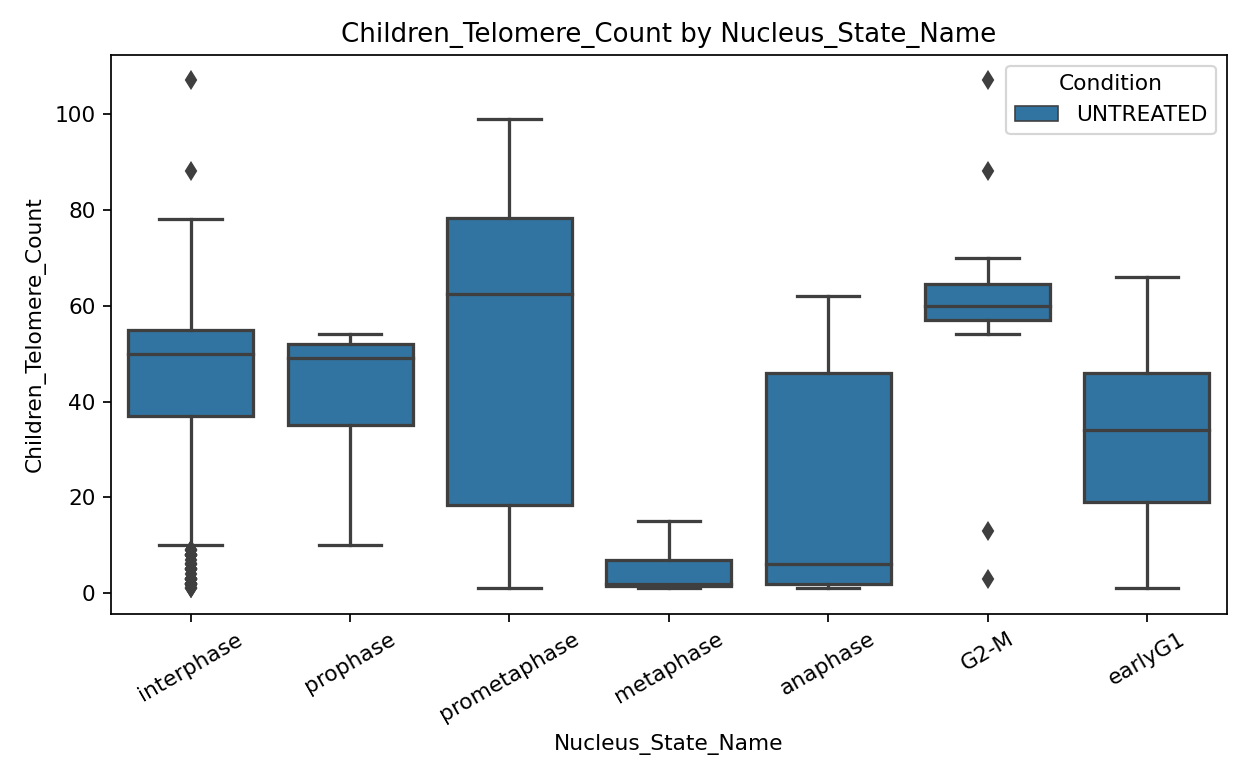

In [77]:
# boxplot

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.boxplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder);
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title(yvar+" by "+xvar);
plt.tight_layout();

In [78]:
# save the above fig
filename = os.path.join(base_input_spath_fig,"Boxplot_"+yvar+"_"+huevar+"_extended.png")
fig.savefig(filename,dpi=300)

#### Swarm Plot

Run the cell below for swarm plot.
**Note**: it takes much longer than boxplot.

<IPython.core.display.Javascript object>


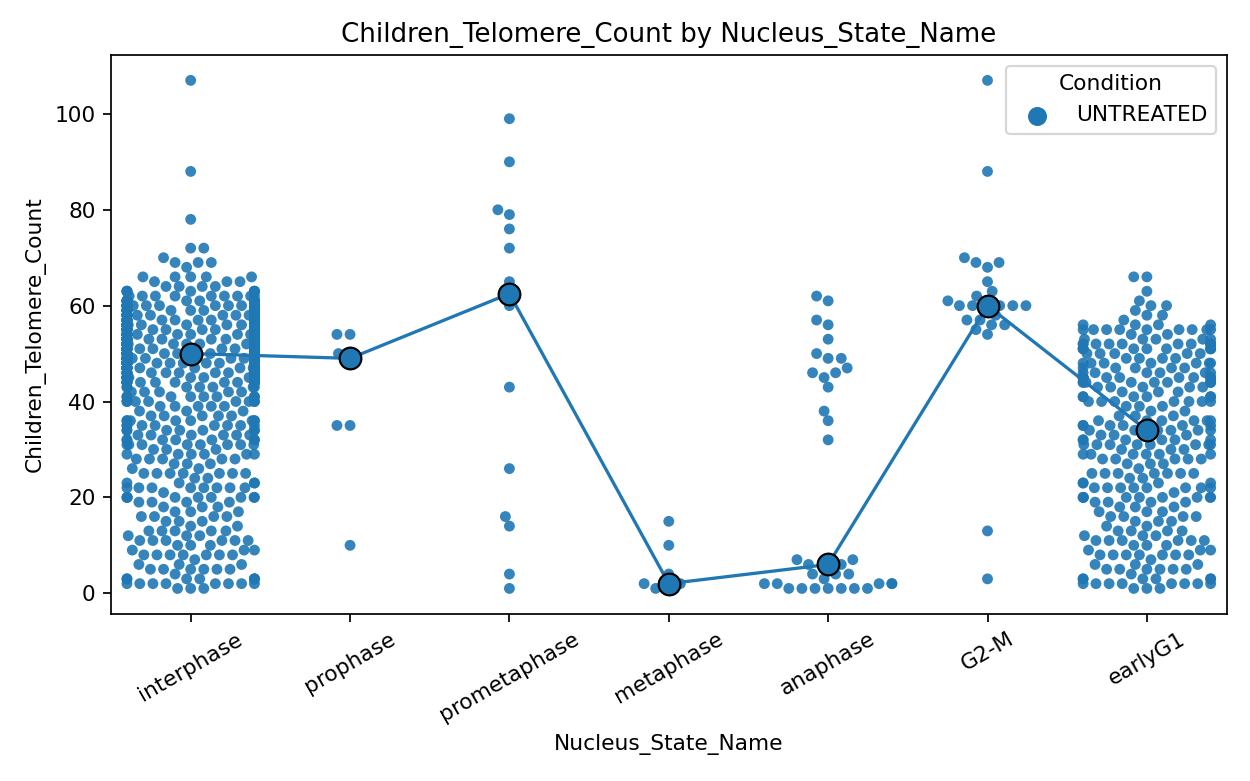

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 60.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [79]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# plot medians
for lbl in huelbl:
    ax.plot(grmed[lbl].index.values-1,grmed[lbl].values,'-o', ms=10, markeredgecolor='black', zorder=1000)

sns.swarmplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder, alpha=0.9);
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title(yvar + " by " + xvar);
plt.tight_layout();

#### Split Violin Plot

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# plot medians
for lbl in huelbl:
    ax.plot(grmed[lbl].index.values-1,grmed[lbl].values,'-o', ms=5, markeredgecolor='black', zorder=1000)

sns.violinplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder, alpha=0.9, split=True);
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title(yvar + " by " + xvar);
plt.tight_layout();

# ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
#                     data=tips, palette="muted", split=True)

In [ ]:
# save the above fig
filename = os.path.join(base_input_spath_fig,"Swarmplot_"+yvar+"_"+huevar+"_extended.png")
fig.savefig(filename,dpi=300)

### TO BE CHECKED Batch processing - legend of boxplots overlapping + ISSUES MEDIAN SWARM

#### Boxplot

https://matplotlib.org/1.3.1/users/recipes.html



from defined reference time interval thr1 > thr2 eg thr1, thr2 = 6,-1
thr1, thr2 = 6,-1

In [2]:
ssdf = sdf.copy() # make a copy

# Adding interphase subgroup with ref time in [-3,0)
c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=thr2
c3 = ssdf["Reference_Time"]<-3
sssdf = ssdf[c1&c2&c3].copy()
# setting new state
sssdf["Nucleus_State_Name"] = "late S (-4 to -3h)"
sssdf["Nucleus_State_Number"] = 7.
ssdf = ssdf.append(sssdf)

# Adding interphase subgroup with ref time in [-3,0)
c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=-3
c3 = ssdf["Reference_Time"]<0
sssdf = ssdf[c1&c2&c3].copy()
# setting new state
sssdf["Nucleus_State_Name"] = "G2 (-3h_t0)"
sssdf["Nucleus_State_Number"] = 8.
ssdf = ssdf.append(sssdf)

# Adding interphase subgroup with ref time in [0,3)
c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=0
c3 = ssdf["Reference_Time"]<3
sssdf = ssdf[c1&c2&c3].copy()
# setting new state
sssdf["Nucleus_State_Name"] = "G1 (t0_+3h)"
sssdf["Nucleus_State_Number"] = 9.
ssdf = ssdf.append(sssdf)

# Adding interphase subgroup with ref time in [3,threshold1]
c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=3
c3 = ssdf["Reference_Time"]<thr1
sssdf = ssdf[c1&c2&c3].copy()
# setting new state
sssdf["Nucleus_State_Name"] = "interphase (>3h postM)"
sssdf["Nucleus_State_Number"] = 10.
ssdf = ssdf.append(sssdf)



# SPECIFY filter by condition, set condlbl = None if we don't want to filter
condlbl = None # can be None, "SICTRL", "SINAMU", etc
if condlbl is not None:
    c1 = (ssdf["Condition"]==condlbl) 
    ssdf = ssdf[c1]
    
# SPECIFY setting plot variables
xvar = "Nucleus_State_Name"
xorder = ["late S (-4 to -3h)","G2 (-3h_t0)","prophase","prometaphase","metaphase","anaphase","G1 (t0_+3h)","interphase (>3h postM)"]
xvar_sup = "Nucleus_State_Number"

# SPECIFY features to plot
yvars = ["AreaShape_Area",
         "AreaShape_Perimeter",
         "AreaShape_FormFactor",
         "Intensity_IntegratedIntensity_H2B_Smooth",
         "Intensity_IntegratedIntensity_TRF1_Smooth",
         "Intensity_MeanIntensity_H2B_Smooth",
         "Intensity_MeanIntensity_TRF1_Smooth",
         "Mean_Telomere_AreaShape_Area",
         "Mean_Telomere_AreaShape_Perimeter",
         "Mean_Telomere_Distance_Minimum_Nuclei",
         "Mean_Telomere_Distance_Centroid_Nuclei",
         "Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth",
         "Children_Telomere_Count"]

# SPECIFY group to plot
huevars = ["Condition"] # can be "Condition", "Date", "Clone" or ["Condition","Clone","Date"]
    
# boxplot
for huevar in huevars:
    for yvar in yvars:
        # computing medians
        grmed = ssdf.groupby([huevar,xvar_sup])[yvar].median()
        huelbl = grmed.index.get_level_values(huevar).unique().values
        
        # plotting
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        sns.boxplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder);
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
       
        ax.set_title(yvar+"_by_"+xvar);
        if condlbl is not None:
            filename = os.path.join(base_input_spath_box,"_extra_"+yvar+"_by_"+xvar+"_"+huevar+"_"+condlbl+".png")
        else:
            filename = os.path.join(base_input_spath_box,"_extra_"+yvar+"_by_"+xvar+"_"+huevar+".png")
        fig.savefig(filename,dpi=300)
        plt.close(fig)

NameError: name 'sdf' is not defined

#### TO BE CHECKED Swarmplot ISSUES WITH MEDIAN